In [1]:
"""
Sliding and Hopping on DNA.

This is a python script that analyses the position of a protein relative to the DNA axis to understand 
if the protein is either in free (3-dimensional) or 1-dimensional diffusion. If in 1-dimensional diffusion 
it will distinguish rotation-coupled groove tracking and decoupled hopping. It contains packages for reading in 
data, sorting the frames according into 1D- and 3D-diffusion firstly and next in groove tracking and hopping. 
It is suited for dimeric DNA-binding proteins 
and checks for symmetric and asymmetric sliding, with both or only one DBD of dimers bound. 
Further packages take care of statistical analysis and plotting.

The input is a csv file that contains the distance from the DNA, the position along the DNA axis
and the angle relative to the DNA-axis (z-axis of the coordinate system) and the x-axis of the 
coordinate system.

"""

'\nSliding and Hopping on DNA.\n\nThis is a python script that analyses the position of a protein relative to the DNA axis to understand \nif the protein is either in free (3-dimensional) or 1-dimensional diffusion. If in 1-dimensional diffusion \nit will distinguish rotation-coupled groove tracking and decoupled hopping. It contains packages for reading in \ndata, sorting the frames according into 1D- and 3D-diffusion firstly and next in groove tracking and hopping. \nIt is suited for dimeric DNA-binding proteins \nand checks for symmetric and asymmetric sliding, with both or only one DBD of dimers bound. \nFurther packages take care of statistical analysis and plotting.\n\nThe input is a csv file that contains the distance from the DNA, the position along the DNA axis\nand the angle relative to the DNA-axis (z-axis of the coordinate system) and the x-axis of the \ncoordinate system.\n\n'

In [2]:
import matplotlib.pyplot as plt
import glob
import sys
import pandas as pd
import numpy as np
import sortednp as snp
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from matplotlib import rc
rc('font', family='helvetica')
import seaborn as sns
import time
import itertools
import sqlite3
sns.set_context("paper")
sns.set(font_scale=0.9)
sns.set_style("white")

In [3]:
"Some colorbrewer colors you can use."
p1 = np.array([224/256, 236/256, 244/256, 1])
p2 = np.array([158/256, 160/256, 218/256, 1])
p3 = np.array([136/256, 86/256, 167/256, 1])
g1 = np.array([229/256, 245/256, 249/256, 1])
g2 = np.array([153/256, 216/256, 201/256, 1])
g3 = np.array([44/256, 162/256, 95/256, 1])
o1 = np.array([254/256, 232/256, 200/256, 1])
o2 = np.array([253/256, 187/256, 132/256, 1])
o3 = np.array([227/256, 74/256, 51/256, 1])

# Load the Data

In [4]:
"""Define the folders with your input data."""
monomer='/data/monomer/'
dimer='/data/dimer/'
full_dimer='data/full_dimer/'

In [5]:
"""for test purpose"""
monomer='/Users/mallu899/Mirror/projects/lacI_CG_master/data/Mono_txt_20/'
dimer='/Users/mallu899/Mirror/projects/lacI_CG_master/data/dimer_RS_txt/'
full_dimer='/Users/mallu899/Mirror/projects/lacI_CG_master/data/fullLength_txt/trajectory_classify_diffusion/'

In [6]:
def import_displacement_csv_as_dataframe(file, nframes):
    """
    Import data from the displacement trajectory analysis.

    Parameter
    ---------
        file : str
            The folder location with the trajectory analysis output files containing distance,
            position and angle of the protein region of interetst relative to the DNA axis.
        nrows : int
            The number rows in the dataframe.

    Returns
    -------
        A pandas DataFrame table with columns
               'distance' (Å) ,'position' (Å),'angle' (degrees).
    """
    
    data = np.array(pd.read_csv(file,sep='\s+',header=None,nrows=nframes))
    
    d = {'distance': data[:,1],
        'position': data[:,0],
        'angle': data[:,2]*(180/np.pi)} #angle from radians to degrees
    dataframe=pd.DataFrame(d)
    #print(dataframe)
    return (dataframe)

class TrajectoryToDataFrame():
    """
    Class that obtains the analysis of the protein, either monomeric or dimeric, 
    in form of a pandas Dataframe 
    or a list of Dataframes for DNA-binding domains A and B in a dimer.
    
    Methods
    -------
    dimer(folder,nframes=100000)
        Analysis for dimeric DNA-binding proteins.
        
    monomer(folder,nframes=100000)
        Analysis for monomeric DNA-binding proteins.       
    """
    
    def dimer(folder,nframes=100000):
        """Import data from the displacement trajectory analysis.

        Parameter
        ---------
            folder (str): The folder location with the displacement
                          trajectory analysis output files.
            nframes (int): number of frames to import

        Returns
        -------
            tuple: of two lists of pandas DataFrames with columns
                   'distance','position','angle'.
                   The two lists correspond to the monomer A and B.
        """

        filesA = sorted(glob.glob(folder+'*Displacement_H2A.txt'))
        filesB = sorted(glob.glob(folder+'*Displacement_H2B.txt'))
        if len(filesA) != len(filesB):
            raise ImportError('Number of files for A and B must be the same')
        dataframes = []
        files = (filesA,filesB)
        for i in range(2): #two times for dimer
            dataframes_ = []
            for file in files[i]:
                dataframes_.append(import_displacement_csv_as_dataframe(file,nframes))
            dataframes.append(dataframes_)

        return tuple(dataframes)
    
    def monomer(folder,nframes=100000):
        """Import data from the displacement trajectory analysis for the monomer.
        
        Parameter
        ---------
            folder (str): The folder location with the displacement
                          trajectory analysis output files named as
                          '*Displacement_*.txt' 
            nframes (int): number of frames to import

        Returns
        -------
            tuple: of two lists of pandas DataFrames with columns
                   'distance','position','angle'.
                   
        """

        files = sorted(glob.glob(folder+'*Displacement_*.txt'))

        dataframes = []
        files = files
        for file in files:
            dataframes.append(import_displacement_csv_as_dataframe(file,nframes))

        return tuple(dataframes)

In [7]:
monomerS001=TrajectoryToDataFrame.monomer(monomer+'S01/')
monomerS002=TrajectoryToDataFrame.monomer(monomer+'S02/')
monomerS003=TrajectoryToDataFrame.monomer(monomer+'S03/')
monomerS004=TrajectoryToDataFrame.monomer(monomer+'S04/')

monomerR001=TrajectoryToDataFrame.monomer(monomer+'R01/')
monomerR002=TrajectoryToDataFrame.monomer(monomer+'R02/')
monomerR003=TrajectoryToDataFrame.monomer(monomer+'R03/')
monomerR004=TrajectoryToDataFrame.monomer(monomer+'R04/')

dimerS001=TrajectoryToDataFrame.dimer(dimer+'S/001/')
dimerS002=TrajectoryToDataFrame.dimer(dimer+'S/002/')
dimerS003=TrajectoryToDataFrame.dimer(dimer+'S/003/')
dimerS004=TrajectoryToDataFrame.dimer(dimer+'S/004/')
dimerS005=TrajectoryToDataFrame.dimer(dimer+'S/005/')
dimerS006=TrajectoryToDataFrame.dimer(dimer+'S/006/')

dimerR001=TrajectoryToDataFrame.dimer(dimer+'R/001/')
dimerR002=TrajectoryToDataFrame.dimer(dimer+'R/002/')
dimerR003=TrajectoryToDataFrame.dimer(dimer+'R/003/')
dimerR004=TrajectoryToDataFrame.dimer(dimer+'R/004/')
dimerR005=TrajectoryToDataFrame.dimer(dimer+'R/005/')
dimerR006=TrajectoryToDataFrame.dimer(dimer+'R/006/')

full_dimerR001=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/01/')
full_dimerR002=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/02/')
full_dimerR003=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/03/')
full_dimerR004=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/04/')
full_dimerR005=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/05/')
full_dimerR006=TrajectoryToDataFrame.dimer(full_dimer+'R_full_Length_8_replica_A_B/06/')

full_dimerS001=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/01/')
full_dimerS002=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/02/')
full_dimerS003=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/03/')
full_dimerS004=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/04/')
full_dimerS005=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/05/')
full_dimerS006=TrajectoryToDataFrame.dimer(full_dimer+'S_full_Length_8_replica_A_B/06/')

# Code that analyses 1D diffusion, groove tracking and hopping

In [8]:
class Grooves():  
    """The functions of this class are a reference frame used to identify sliding.
    
    They relate the position and the angle 
    along the major grooves center in the static, generic B-DNA. 
     
     
    Methods
    ----------
    f0-f9: int 
         return the angle in degrees for a position in Å.
    f0y-f9y: int 
         return the position for an angle.
    groove_functions_angle
        return list(f0-f9)
    groove_functions_position
        return list(f0y-f9y)
    """
    
    def f0(x):
        return (x*9.78636231)-1410.46658798
    def f0y(y):
        return (y-(-1410.46658798))/9.78636231
    def f1(x):
        return (x*10.43608208)-1157.42910297
    def f1y(y):
        return (y-(-1157.42910297))/10.43608208
    def f2(x):
        return (x*10.43608208)-805.4409265
    def f2y(y):
        return (y-(-805.4409265))/10.43608208
    def f3(x):
        return (x*10.43608208)-453.45275003
    def f3y(y):
        return (y-(-453.45275003))/10.43608208
    def f4(x):
        return (x*10.43608208)-101.46457357
    def f4y(y):
        return (y-(-101.46457357))/10.43608208
    def f5(x):
        return (x*10.43608208)+250.5236029
    def f5y(y):
        return (y-(250.5236029))/10.43608208
    def f6(x):
        return (x*10.43608208)+602.51177936
    def f6y(y):
        return (y-(602.51177936))/10.43608208
    def f7(x):
        return (x*10.43608208)+954.49995583
    def f7y(y):
        return (y-(954.49995583))/10.43608208
    def f8(x):
        return (x*10.43608208)+1306.48813229
    def f8y(y):
        return (y-(1306.48813229))/10.43608208
    def f9(x):
        return (x*10.43608208)+1658.47630876
    def f9y(y):
        return (y-(1658.47630876))/10.43608208
    
    def groove_functions_angle():
        "Functions that obtain the angle for a position."
        return(Grooves.f0,Grooves.f1,Grooves.f2,Grooves.f3,Grooves.f4,Grooves.f5,Grooves.f6,Grooves.f7,Grooves.f8,Grooves.f9)
    
    def groove_functions_position():
        "Functions that obtain the value of position for one angle."
        return(Grooves.f0y,Grooves.f1y,Grooves.f2y,Grooves.f3y,Grooves.f4y,Grooves.f5y,Grooves.f6y,Grooves.f7y,Grooves.f8y,Grooves.f9y)

In [9]:
class ClassifyTrajectory:
    """Keeps only frames of 1D diffusion from the dataframe containing distance, position and angle
    and identifies sliding if check_sliding is called.
    
    Dependencies
    ------------
    Relies on class grooves to identify sliding.
    
    Methods
    -------
    check_dissociation(self, distance_threshold = 32.0)
        Sorts out 3D diffusion according to the distance threshold and
        replaces the distance column with indexes. 
        
    check_sliding(self,angle_cut_off= 34.0)
        Assigned the protein to the groove_indexes defined in Grooves.groove_functions and assignes 0 for hopping.
        This function calls check_dissociation in the first place.
        
    check_sliding_dimer(self,angle_cut_off= 34.0)
        Does the analysis for dimers.
        """
    
    def __init__(self,distance_position_angle_df):
        """
        Parameters
        ----------
        distance_position_angle_df : pd.DataFrame
            The dataframe with distance, position and angle.
        """
        
        self.distance_position_angle_df=distance_position_angle_df

    def __getitem__(self, position):
        """
        Returns
        -------
        One replica at a time."""
        
        return(self[position])
    
    def check_dissociation(self, distance_threshold = 32.0):
        """Function that checks if the protein is further away than a distance_threshold in Å from the DNA axis, 
        where the electrostatic interaction energy drops to less than 10%.
        
        Returns
        -------
        DataFrame with index, position and angle.
        """
        
        dfs=[]
        for df in self:
            df=df[df['distance'] < distance_threshold]
            df=df.reset_index()
            df.drop(columns='distance',inplace=True)
            dfs.append(df)

        return(dfs)
    
    def check_sliding(self,angle_cut_off= 51.0): #1.5 bp
        """Function that checks if the protein is in the groove that is defined by 10 groove_functions
        for the 100 bp generic B-DNA. 
        
        The protein has to be aligned with the center of the groove and can deviate from the angle of 
        the groove center by angle_cut_off degrees.
        
        It calls ClassifyTrajectory.check_dissociation(self) first to obtain only 1D diffusion.
        
        Returns
        -------
        DataFrame with index, position, angle and groove_index, which is 0 if the protein is not in the groove.
        """
        
        dfs=ClassifyTrajectory.check_dissociation(self)
        # Hardcoded parameters
        ZMIN = [145.0, 111.0, 78.0, 44.0, 10.0, -24.0, -57.0, -91.0, -125.0, -159.0]
        ZMAX = [181.0, 145.0, 111.0, 78.0, 44.0, 10.0, -24.0, -57.0, -91.0, -125.0]
          
        dfs_sliding=[]
        groove_indexes=range(1,11)
        groove_function_indexes=range(10)
        for df in dfs:
            df['groove_index']=np.zeros(len(df),dtype=int)
            for j in groove_function_indexes:
                #Check in which groove area the protein is. You get the indexes where a particular j will match.
                ind = df.index[((df['position']>= ZMIN[j]) & (df['position'] <ZMAX[j])) ]
                #get the angle of this groove from the functions
                groove_angle = Grooves.groove_functions_angle()[j](df['position'][ind])
                #and check if the angle in this position is close
                ind2 = ind[np.abs(groove_angle-df['angle'][ind]) <= angle_cut_off]
                df.loc[ind2,'groove_index']=groove_indexes[j]
            dfs_sliding.append(df)
        return(dfs_sliding)
    
    def check_sliding_dimer(self):
        """Obtains indexes, position, angle and groove_indexes for the two DBDs in a dimeric protein.
        
        Returns
        -------
        DataFrame with index, position, angle and groove_index, which is 0 if the protein is not in the groove."""
        
        dfA=ClassifyTrajectory.check_sliding(self[0])
        dfB=ClassifyTrajectory.check_sliding(self[1])
        return(dfA,dfB)
    
    def check_sliding_monomer(self):
        """Obtains indexes, position, angle and groove_indexes a monomeric DBD.
        
        Returns
        -------
        DataFrame with index, position, angle and groove_index, which is 0 if the protein is not in the groove."""
        
        df=ClassifyTrajectory.check_sliding(self)
        return([df])
        

In [10]:
def smoothen_sliding_vs_hopping_old(dataframe):
    """This function checks if hopping is at least 1 bp long. If it is not, it will be 
    counted into slididng, because the protein only shortly slipps out of the groove.
    The same goes for sliding, if it is less than 10 frames long, the protein is rather hopping over the groove.
    
    Parameter
    ---------
    dataframe: pandas Dataframe
    
    Returns
    -------
    dataframe_new: updated pandas Dataframe"""
    
    data_add_slide_start_end=np.append(np.append(1,dataframe['groove_index_bin']),1)
    diff_data = np.diff(data_add_slide_start_end)
    (hop_starts,) = np.where(diff_data==-1)
    (hop_ends,) = np.where(diff_data==1)
    hop_lens = hop_ends-hop_starts
    
    dataframe_1=dataframe['groove_index_bin'].copy()
    for i in range(len(hop_lens)):
        if hop_lens[i] < 30:
            dataframe_1.iloc[hop_starts[i]:hop_ends[i]] = 1
    
    data_add_slide_start_end=np.append(np.append(1,dataframe_1),1)
    diff_data=np.diff(data_add_slide_start_end)
    (slide_starts,) = np.where(diff_data==1)
    (slide_ends,) = np.where(diff_data==-1)
    slide_lens = slide_ends-slide_starts
    
    dataframe_new=dataframe_1.copy()
    for i in range(len(slide_lens)):
        if slide_lens[i] < 10:
            dataframe_new.iloc[slide_starts[i]:slide_ends[i]] = 0
    return(dataframe_new)

def smoothen_sliding_vs_hopping(dataframe):
    """This function checks if hopping is at least 10 frames long. If it is not, it will be 
    counted into sliding, because the protein only shortly slipps out of the groove.
    The same goes for sliding, if it is less than 10 frames long, the protein is rather hopping over the groove.
    
    Parameter
    ---------
    dataframe: pandas Dataframe
    
    Returns
    -------
    dataframe_new: updated pandas Dataframe"""
    
    #data_add_slide_start_end=np.append(np.append(1,dataframe['groove_index_bin']),1)
    data_add_slide_start_end=np.append(np.append(1,dataframe['groove_index_bin']),1)
    diff_data = np.diff(data_add_slide_start_end)
    (hop_starts,) = np.where(diff_data==-1)
    (hop_ends,) = np.where(diff_data==1)
    
    hop_ends -= 1
 
                             
    dataframe_1=dataframe['groove_index_bin'].copy()
    #return(dataframe_1)
    for i in range(len(hop_starts)):
        hop_len = np.abs(dataframe.iloc[hop_ends[i]]['position']-\
                            dataframe.iloc[hop_starts[i]]['position'])
        #hop_lens = dataframe.iloc[hop_ends[i]]['index']-\
        #                    dataframe.iloc[hop_starts[i]]['index']
        if hop_len < 3.4:
            #print('update dataframe')
            dataframe_1.iloc[hop_starts[i]:hop_ends[i]+1] = 1
    #return(dataframe_1)
    
    data_add_slide_start_end=np.append(np.append(0,dataframe_1),0)
    diff_data=np.diff(data_add_slide_start_end)
    (slide_starts,) = np.where(diff_data==1)
    (slide_ends,) = np.where(diff_data==-1)
    slide_ends -= 1
    slide_lens = slide_ends-slide_starts+1
    dataframe_new=dataframe_1.copy()
    for i in range(len(slide_lens)):
        if slide_lens[i] < 10:
            dataframe_new.iloc[slide_starts[i]:slide_ends[i]+1] = 0
    return(dataframe_new)

def start_end_dataframe(start_df,end_df,protein_descriptor,replica):
    """Function that transfers dataframes with start and end frames and positions into one dataframe.
    
    Parameters
    ----------
    start_df: Pandas DataFrame
    end_df: Pandas DataFrame
    protein_descriptor: str
    replica: str
    
    Returns
    -------
    A pandas DataFrame containing start- and end-frames and -positions as well as a protein descriptor 
    and the replica record.
    """
    
    assert len(start_df)==len(end_df), 'Number of start and end frames must be the same'
    
    data={'start_frame':[int(x) for x in start_df['index'] ],
          'end_frame':[int(x) for x in end_df['index']],
          'start_position':[float(x) for x in start_df['position'] ],
          'end_position':[float(x) for x in end_df['position']],
          'protein':[protein_descriptor for x in start_df.index],
          'replica':[replica for x in start_df.index]}
    
    df=pd.DataFrame(data)
    return(df)

def get_start_end_sliding(D1_diffusion_dataFrame,protein_descriptor,replica):
    """Split 1D diffusion in intervalls of sliding and hopping.
    
    Parameters
    ----------
    D1_diffusion_dataFrame : pandas DataFrame
        Contains frame, position, angle and groove_index. The length is minimal 100 frames (rows).
    rolling_window: int
        Value for the costum function that will roll over half of the intervall in each direction.
    protein_descriptor: str
    replica: str
    
    Returns
    -------
    sliding_start_end_dataframe : pandas DataFrame
        Contains start and end frames and positions of sliding.
    """    
    
    #get the binary groove indicators and smoothen the data with rolling widows
    D1_diffusion_dataFrame['groove_index_bin'] = [0.0 if x==0.0 else 1.0 for x in D1_diffusion_dataFrame.\
                                                groove_index]
    D1_diffusion_dataFrame['groove_index_bin_smooth'] = smoothen_sliding_vs_hopping(D1_diffusion_dataFrame)
    #return(D1_diffusion_dataFrame)
    D1_diffusion_dataFrame_reindex = D1_diffusion_dataFrame.reset_index()#.drop(columns='index')
        
    smooth_groove_indexes = np.array(D1_diffusion_dataFrame_reindex['groove_index_bin_smooth'])
    diff_groove_indexes_ = np.append(np.append(0,smooth_groove_indexes),0)
    #diff_groove_indexes_[-1] = 0
    diff_groove_indexes = np.diff(diff_groove_indexes_)
    (slide_starts,) = np.where(diff_groove_indexes == 1)
    (slide_ends,) = np.where(diff_groove_indexes == -1)
    slide_ends -= 1
    slide_start_dfs = D1_diffusion_dataFrame_reindex.iloc[slide_starts]
    slide_end_dfs = D1_diffusion_dataFrame_reindex.iloc[slide_ends]
    

    sliding = start_end_dataframe(slide_start_dfs,slide_end_dfs,protein_descriptor,replica)
    return(sliding)

In [12]:
class QuantifyDiffusionSlidingAndHopping:

    """ 
    Qunatify 1D-diffusion, sliding and hopping in bp and ms.
    
    Class that will define intervalls of 1D diffusion, sliding and hopping to estimate the time spent
    in each diffusional mode and the distance the protein has travelled during this time.
    
    Methods
    -------
    D1_diffusion(self,for_sliding_vs_hopping=False):
        Returns frames of 1D diffusion or a dataframe with start and end values of 1D diffusion for different 
        protein subunits, if the analysed protein is a multimer, and different replica.
    sliding_and_hopping(self)
        Returns the a dataframe with start and end values for sliding.
    """
    
    def __init__(self,index_position_angle_df,protein_description,\
                 multimer_subscripts=[' A',' B']):
        """
        Parameters
        ----------
        index_position_angle_df: pandas DataFrame 
            DataFrame containing Frame indexes,  positions, angles and groove_indixes obtained from coarse-
            grained simulations after processing by the TrajectoryToDataFrame and ClassifyTrajectory modules.
            
        protein_description: str
            Input a protein description for the resulting DataFrame.
            
        multimer_subscripts: str, default [' A',' B'] for dimers
        
            Input a list of subscripts for the protein subunits.
        """
    
        self.index_position_angle_df = index_position_angle_df
        self.protein_description = protein_description
        self.multimer_subscripts = multimer_subscripts
        
    def D1_diffusion(self,for_sliding_vs_hopping=False):
        """
        Function that determines start and end frames, intervalls, of 1D diffusion on DNA.
        
        The protein is in free diffusion, when the index count breaks.
        Sometimes the protein comes closer than 32 Å but will dissociate quickly.
        If dissociation occurs within 5 us (100 frames), 
        no 1D diffusion is counted and the frames will be dropped from the DataFrame.
        
        Parameters
        ----------
        for_sliding_vs_hopping: bol, Default:False
        
        Returns
        -------
        List of List of DataFrames with 1D frames: 
        index, position, angle, groove_index if for_sliding_vs_hopping = True, 
        or only start and end frames if for_sliding_vs_hopping = False in a DataFrame that will 
        contain information on the protein, e.g. dimer for a dimer where subscripts, e.g. A and B,
        will be added if there is information for both monomers. Other subscript can be passed to 
        the class with the multimer_subscripts option.
        
        """
        
        oneDdiffusion = []
        oneDdiffusion_start_end = []
        protein_descriptor = []
        replica = []
        for i in range(len(self.index_position_angle_df)): #iterate over monomers
            monomer_data = self.index_position_angle_df[i]
            oneDdiffusion_monomer = [] 
            subscript=self.multimer_subscripts[i]
            for j in range( len(monomer_data) ): #iterate over replica
                data_frame = monomer_data[j]
                oneDdiffusion_replica = [] 

                if len(data_frame)==100000:
                    #print('One 1D round')
                    oneDdiffusion_replica.append(data_frame)   #no 3D diffusion
                    oneDdiffusion_start_end.append((data_frame.iloc[0],data_frame.iloc[-1]))
                    protein_descriptor.append(self.protein_description+subscript)
                    replica.append(j+1)
                else:
                    broken_indexes=[x for (x,y) in list(enumerate( np.diff(data_frame['index']) )) if y != 1]
                    broken_indexes.append(len(data_frame)-1)
                    start=0
                    #check if you end of the first round is bigger than start
                    for end_index in broken_indexes:
                        D1 = data_frame.iloc[start:end_index]
                        D1_start_end=(data_frame.iloc[start],data_frame.iloc[end_index])
                        if len(D1) > 100:
                            oneDdiffusion_replica.append(D1)
                            oneDdiffusion_start_end.append(D1_start_end)
                            protein_descriptor.append(self.protein_description+subscript)
                            replica.append(j+1)
                        start=end_index+1
  
                oneDdiffusion_monomer.append(oneDdiffusion_replica)
            oneDdiffusion.append(oneDdiffusion_monomer)

        #write 1D diffusion to a dataframe containing the start and end indices and positions
        data={'start_frame':[x[0]['index'] for x in oneDdiffusion_start_end],
              'end_frame':[x[1]['index'] for x in oneDdiffusion_start_end],
              'start_position':[x[0]['position'] for x in oneDdiffusion_start_end],
              'end_position':[x[1]['position'] for x in oneDdiffusion_start_end],
             'protein':protein_descriptor,'replica':replica}
        df=pd.DataFrame(data)
        #print(len(replica),len(protein_descriptor),len(oneDdiffusion_start_end))
        if for_sliding_vs_hopping:
            return(oneDdiffusion)
        else:
            return(df)
    
    def sliding_and_hopping(self):
        """
        Identify sliding versus hopping with the 0 and function index notation after 
        invoking D1_diffusion.
        
        Parameters
        ----------
        self.index_position_angle_df and self.protein_description
        
        Dependencies
        ------------
        QuantifyDiffusionSlidingAndHopping.D1_diffusion
            with the option for_sliding_vs_hopping=True to obtain the DataFrame with 
            all the frames
            during 1D diffusion that will be split into sliding and hopping.
        start_end_sliding 
            to do the actual analysis of sliding and hopping intervalls
        start_end_dataframe
            for formatting of the final pandas dataframe
            
        Returns
        -------
        oneDdiffusion_sliding: list of list of pandas Dataframe
            containing the start and end frames and positions of sliding events 
            plus information of the protein
            and the replica of the simulation. One dataframe is for one replica and 
            the data is in turns split into
            monomers, so there will be two lists of dataframes for a dimer.
        """
            
        oneDdiffusion=QuantifyDiffusionSlidingAndHopping(self.index_position_angle_df, \
            self.protein_description).D1_diffusion(for_sliding_vs_hopping=True)
        oneDdiffusion_sliding=[]
        for i in range(len(oneDdiffusion)):     #iterate over monomers
            monomer_data = oneDdiffusion[i]
            subscript=self.multimer_subscripts[i]
            protein_descriptor=self.protein_description+subscript
            sliding_hopping_monomer = [] 
            for replica_data_count in range(len(monomer_data)): #iterate over replica
                replica_data = monomer_data[replica_data_count]
                sliding_hopping_replica = []
                for D1_data_frame in replica_data:         #iterate over rounds of 1D diffusion 
                    starts_ends_sliding=get_start_end_sliding(D1_data_frame,\
                        protein_descriptor,replica_data_count+1)
                    if isinstance(starts_ends_sliding,pd.DataFrame):
                        sliding_hopping_replica.append(starts_ends_sliding) 
                        
 
                if sliding_hopping_replica!=[]:
                    sliding_hopping_replica_one_df=pd.concat([interval for interval \
                                                              in sliding_hopping_replica])
                    sliding_hopping_monomer.append(sliding_hopping_replica_one_df)
                else:
                    sliding_hopping_monomer.append(None)
            oneDdiffusion_sliding.append(sliding_hopping_monomer)

        return(oneDdiffusion_sliding) 


## Make a test for this part of the code before you move on to averaging

#### Check for *sliding*

In [12]:
#ClassifyTrajectory.check_sliding_dimer(full_dimerS003)

#### 1D diffusion

In [13]:
test=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS003),'dimer').sliding_and_hopping()

/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(full_dimerS003),'dimer').D1_diffusion()

,start_frame,end_frame,start_position,end_position,protein,replica
0,0.0,636.0,-14.863,-37.127,dimer A,1
1,694.0,25173.0,-37.552,-17.490,dimer A,1
2,26777.0,26902.0,63.689,55.518,dimer A,1
3,34132.0,34334.0,17.110,17.667,dimer A,1
4,34629.0,47003.0,21.005,33.098,dimer A,1
...,...,...,...,...,...,...
225,70712.0,70818.0,-25.246,-34.322,dimer B,8
226,71394.0,74566.0,-25.060,-26.966,dimer B,8
227,75119.0,75304.0,-36.161,-40.840,dimer B,8
228,76087.0,76465.0,-36.942,-40.790,dimer B,8


## More scripts to analyse the output from analysis fo 1D diffusion and *sliding*

In [15]:
def hopping_from_sliding(sliding_start_end_frame):
    """Obtains a dataframe with start and end information on hopping from the same information on sliding.
    
    Parameters
    ----------
    sliding_start_end_frame : pandas DataFrame
        Contains start and end frames and positions of sliding.
        
    Returns
    -------
    hopping_start_end_dataframe : pandas DataFrame
        Contains start and end frames and positions of hopping."""
    
    if not isinstance(sliding_start_end_frame,pd.DataFrame):
        return([])
    
    data_hopping={'start_frame':np.array(sliding_start_end_frame['end_frame'][:-1]+1),
                      'end_frame':np.array(sliding_start_end_frame['start_frame'][1:]-1),
                      'start_position':np.array(sliding_start_end_frame['end_position'][:-1]),
                      'end_position':np.array(sliding_start_end_frame['start_position'][1:]-1),
                     'protein':np.array(sliding_start_end_frame['protein'][:-1]),
                    'replica':np.array(sliding_start_end_frame['replica'][:-1])}
    
    hopping_start_end_dataframe=pd.DataFrame(data_hopping)
    return(hopping_start_end_dataframe)

def measure_slides_and_hops(dataframe_start_end):
    """Measure the distance travelled during slides and hops along the Z-axis.
    
    Input
    -----
    dataframe_start_end : pandas DataFrame
    
    Returns
    -------
    dataframe_start_end_distance_time : pandas DataFrame
    """ 
    
    if not isinstance(dataframe_start_end,pd.DataFrame):
        return([])
    time = ( dataframe_start_end['end_frame']-dataframe_start_end['start_frame'] )*0.05*10**(-3) 
    #converting steps to ms
    dist = np.sqrt( (dataframe_start_end['end_position']-dataframe_start_end['start_position'])**2 ) /3.3 
    #converting Å in bp

    dataframe_start_end['time (ms)'] = time
    dataframe_start_end['distance (bp)'] = dist
    dataframe_start_end_distance_time = dataframe_start_end

    return(dataframe_start_end_distance_time )

In [16]:
def paired_lists(list_a,list_b):
    """Uses numpy meshgrid to get all combinations of values from two lists.

    Parameters
    ----------
    list_a,list_b: list or pandas Dataframe column
        Lists with values to be paired.

    Returns
    -------
    A list of vectors with all possible pairs for the values in the two lists."""

    a2,b2 = np.meshgrid( np.array(list_a),np.array(list_b) )

    #np.array(x,y) for x,y in zip(
    a2_ = [x for y in a2 for x in y]
    b2_ = [x for y in b2 for x in y]
    vectors = [(a,b) for a,b in zip(a2_,b2_)]
    return(vectors)

In [17]:
class Dimer:
    """Contains functions that summarize the data from two pandas DataFrames with information for one dimer. 
    
    Obtain data that can easily be statsitically ananlysed and plotted.
    
    Methods
    -------

    identify_symmetric_events
        Get a list of common start and end frames in overlapping intervalls of hopping or sliding in both DNA
        binidng domains (DBDs).
    
    merge_symmetric
        Collect the rows of overlapping events write them into seperate dataframes. Get the asymmetric events
        in two seperate dataframes, which contain either only data from DBD A or DBD B.
    
    symmetric_asymmetric_df
        Write one dataframe with symmetric and asymmetric events and their respective start and end frames, 
        positions, times and distances as well as a note on their symmetry, the kind of protein and 
    
    check_flips: doesn't work
    
    combine_replica:
        combined all the data for different replicas and keeps track of them in an extra column.
    """


    def identify_symmetric_events(dataframe_A,dataframe_B):  
        """Funtion that identifies overlapping intervalls of start and end values from two dataframes.

        The function also takes care if these combined intervals are overlapping themselves.

        Dependencies
        ------------
        Uses paired_lists to obtain all possible combinations of start/end values in A and B.

        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of events
            
        Returns
        -------
        A list of lists containing a start and end value for a combined interval.
        """
        
        #print(dataframe_A,dataframe_B)
        if not isinstance(dataframe_A,pd.DataFrame):
            if isinstance(dataframe_B,pd.DataFrame):
                return(dataframe_B)
            else:
                return([])
        elif not isinstance(dataframe_B,pd.DataFrame):
            return(dataframe_A)

        end_pairs = paired_lists(dataframe_A['end_frame'],dataframe_B['end_frame'])
        start_pairs = paired_lists(dataframe_A['start_frame'],dataframe_B['start_frame'])
        symmetric_intervals=[ [min(starts),max(ends)] for ends,starts in zip(end_pairs,start_pairs) \
                             if min(ends) > max(starts) ]
        #https://stackoverflow.com/questions/43600878/merging-overlapping-intervals
        if len(symmetric_intervals)==0:
            return([])
        merged = [symmetric_intervals[0]]
        for current in symmetric_intervals[1:]:
            previous = merged[-1]
            if current[0] <= previous[1]:
                previous[1] = max(previous[1], current[1])
            else:
                merged.append(current)
        return(merged)

    def merge_symmetric(dataframe_A,dataframe_B,symmetric_frame_interval):
        """Function that combines the domain-specific data if it is specified as symmetric.

        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of events
        symmetric_frame_interval: list if pair lists
            Contains the intervals of overlap, the minimum start and maximum end values of the combined event.

        Returns
        -------
        symmetric: list of pandas DataFrames
            A list of dataframes that contain domainspecific data rows if it is falling into a common interval
        asymmetric_a,asymmetric_b: pandas DataFrames
            Two dataframes containing the solo events .
        """
        
        symmetric = []
        for interval in range(len(symmetric_frame_interval)): #this iterates over the symmetric intervals
            interval_df=pd.DataFrame(columns=dataframe_A.columns)
            #collect all rows that lie within the interval of symmetric slides
            symmetric_a = dataframe_A[((dataframe_A['start_frame'] >= symmetric_frame_interval[interval][0]) \
                          & (dataframe_A['start_frame'] <= symmetric_frame_interval[interval][1]))]
            symmetric_b = dataframe_B[((dataframe_B['start_frame'] >= symmetric_frame_interval[interval][0]) \
                          & (dataframe_B['start_frame'] <= symmetric_frame_interval[interval][1]))]
            interval_df=interval_df.append(symmetric_a)
            interval_df=interval_df.append(symmetric_b)
            symmetric.append(interval_df)
        if symmetric==[]: #only asymmetric
            return([],dataframe_A,dataframe_B)
        else:
            #make the test if you got all rows sorted into symmetric and asymmetric and get asymmetric events
            #For some reason this is not perfectly working for slides!
            
            symmetric_all_starts=pd.concat([x for x in symmetric])['start_frame'] 
            
            asymmetric_a = dataframe_A[~dataframe_A['start_frame'].isin(symmetric_all_starts)]
            asymmetric_b = dataframe_B[~dataframe_B['start_frame'].isin(symmetric_all_starts)]
            
            test_after_splitting=pd.concat([pd.concat([x for x in symmetric]),asymmetric_a,asymmetric_b]).sort_values(by='start_frame').reset_index()
            test_before_splitting=pd.concat([dataframe_A,dataframe_B]).sort_values(by='start_frame').reset_index()
            test=test_after_splitting==test_before_splitting
            if test.all().all():
                print('OK!')
            else:
                print(len(test_after_splitting),len(test_before_splitting))
            return(symmetric,asymmetric_a,asymmetric_b)

    def symmetric_asymmetric_df(dataframe_A,dataframe_B,protein_info='search conformation',condition=0.02):
        """Writes a dataframe with max times and distances for symmetric events and the asymmetric events.

        Dependencies
        ------------
        Uses paired_lists to obtain all possible combinations of start/end values in A and B.  

        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of events
        protein_info: str
            Write the info for the protein. e.g. 'search conformation'
        condition: int
            Here give the salt. e.g. 0.02 (not really molar)-
        Returns
        -------
        df_sym_asym_intervals: pandas DataFrames
            Contains the interval measurements, time in ms and distance in bp, as well as information about
            the protein and the salt concentration.
        """

        symmetric_frame_interval=Dimer.identify_symmetric_events(dataframe_A,dataframe_B)
        if len(symmetric_frame_interval)==[]:
            return([])
        
        elif isinstance(symmetric_frame_interval,pd.DataFrame):
            df_asym_intervals=symmetric_frame_interval
            df_asym_intervals['symmetry']='asymmetric'
            df_asym_intervals['protein']=[protein_info for x in df_asym_intervals.index]
            df_asym_intervals['salt']=[condition for x in df_asym_intervals.index]
            print('Return only asymmeric events because no symmetric events were found.')
            return(df_asym_intervals)
        
        else:
            sym,asym_a,asym_b=Dimer.merge_symmetric(dataframe_A,dataframe_B,symmetric_frame_interval)
        
            if len(sym)==0:
                if isinstance(asym_a,pd.DataFrame):
                    if isinstance(asym_b,pd.DataFrame):
                        df_asym_intervals=pd.concat([asym_a,asym_b])
                    else:
                        df_asym_intervals=asym_a
                else:
                    if isinstance(asym_b,pd.DataFrame):
                        df_asym_intervals=asym_b
                    else:
                        return([])

                print('Return only asymmeric events')
                df_asym_intervals['symmetry']='asymmetric' 
                df_asym_intervals['protein']=[protein_info for x in df_asym_intervals.index]
                df_asym_intervals['salt']=[condition for x in df_asym_intervals.index]
                return(df_asym_intervals)

            else:
                df_asym_intervals=pd.concat([asym_a,asym_b])
                df_sym_intervals=sym[0].groupby('replica', as_index=False).agg({'start_frame':'min',\
                'end_frame':'max'})
                #get the positions
                #print(df_sym_intervals,sym[0])
                start_position=sym[0][sym[0]['start_frame']==df_sym_intervals['start_frame'].values[0]]['start_position'].values[0]
                #print(start_position)
                start_domain=sym[0][sym[0]['start_frame']==df_sym_intervals['start_frame'].values[0]]['protein'].values[0]
                end_position=sym[0][sym[0]['protein']==start_domain].iloc[-1]['end_position']
                #Measure the new distances and times for symmetric events
                df_sym_intervals['start_position']=[start_position]
                df_sym_intervals['end_position']=[end_position]
                df_sym_intervals_time_dist=measure_slides_and_hops(df_sym_intervals)
                df_sym_intervals_time_dist['symmetry']='symmetric'
                A_start=sym[0][sym[0]['protein']=='dimer A'].iloc[0]['start_position'].astype(float)
                B_start=sym[0][sym[0]['protein']=='dimer B'].iloc[0]['start_position'].astype(float)
                df_sym_intervals_time_dist['flip_sign']=A_start-B_start

                if len(sym)==2:
                    df_sym_interval=sym[1].groupby('replica', as_index=False).agg({'start_frame':'min',\
                                    'end_frame':'max'})
                                    #get the positions
                    start_position=sym[1][sym[1]['start_frame']==df_sym_interval['start_frame'].values[0]]['start_position'].values[0]
                    start_domain=sym[1][sym[1]['start_frame']==df_sym_interval['start_frame'].values[0]]['protein'].values[0]
                    end_position=sym[1][sym[1]['protein']==start_domain].iloc[-1]['end_position']
                                    #Measure the new distances and times for symmetric events
                    df_sym_interval['start_position']=[start_position]
                    df_sym_interval['end_position']=[end_position]
                    df_sym_interval_time_dist=measure_slides_and_hops(df_sym_interval)
                    df_sym_interval_time_dist['symmetry']='symmetric'
                    A_start=sym[1][sym[1]['protein']=='dimer A'].iloc[0]['start_position'].astype(float)
                    B_start=sym[1][sym[1]['protein']=='dimer B'].iloc[0]['start_position'].astype(float)
                                    #print(A_start)
                    df_sym_interval_time_dist['flip_sign']=A_start-B_start
                    df_sym_intervals_time_dist = df_sym_intervals_time_dist.append(df_sym_interval_time_dist)
                else:
                    for i in range(1,len(sym)):
                        df_sym_interval=sym[i].groupby('replica', as_index=False).agg({'start_frame':'min',\
                                        'end_frame':'max'})
                                        #get the positions
                        start_position=sym[i][sym[i]['start_frame']==df_sym_interval['start_frame'].values[0]]['start_position'].values[0]
                        start_domain=sym[i][sym[i]['start_frame']==df_sym_interval['start_frame'].values[0]]['protein'].values[0]
                        end_position=sym[i][sym[i]['protein']==start_domain].iloc[-1]['end_position']
                                        #Measure the new distances and times for symmetric events
                        df_sym_interval['start_position']=[start_position]
                        df_sym_interval['end_position']=[end_position]
                        df_sym_interval_time_dist=measure_slides_and_hops(df_sym_interval)
                        df_sym_interval_time_dist['symmetry']='symmetric'
                        A_start=sym[i][sym[i]['protein']=='dimer A'].iloc[0]['start_position'].astype(float)
                        B_start=sym[i][sym[i]['protein']=='dimer B'].iloc[0]['start_position'].astype(float)
                                        #print(A_start)
                        df_sym_interval_time_dist['flip_sign']=A_start-B_start
                        df_sym_intervals_time_dist = df_sym_intervals_time_dist.append(df_sym_interval_time_dist)
                    
                
                if df_asym_intervals.empty:
                    df_sym_asym_intervals=df_sym_intervals_time_dist
                else:
                    df_asym_intervals['symmetry']='asymmetric'
                    df_sym_asym_intervals=pd.concat([df_sym_intervals_time_dist,df_asym_intervals])        
                df_sym_asym_intervals['protein']=[protein_info for x in df_sym_asym_intervals.index]
                df_sym_asym_intervals['salt']=[condition for x in df_sym_asym_intervals.index]
                return(df_sym_asym_intervals)

    def check_flips(sliding):
        #This function is noy working jet!!
        """Count flips.


        Parameters
        ----------
        dataframe_A,dataframe_B: Pandas Dataframes
            Containing start and end frames of SLIDING only

        Returns
        -------
        flips: int
            Number of flips in the trajectory.
        """
        
        symmetric_sliding=sliding[sliding['symmetry']=='symmetric']
        if len(symmetric_sliding)==0:
            return(0)
        else:
            flips_sign=np.sign(symmetric_sliding['flip_sign'])
            #https://stackoverflow.com/questions/2936834/python-counting-sign-changes
            flips_N=len(list(itertools.groupby(flips_sign, lambda flips_sign: flips_sign > 0)))
            return(flips_N)
        
    def hopping_frequency(hopping_df): 
        """Counts all hops longer than 2 bp, shorter than 100 bp.
        
        Parameters
        ----------
        hopping_df: pandas dataframe
        
        Returns
        -------
        counts_per_ms: list of intergers
            A list of hops per ms for each trajectory.
        """
        
        long_hopping=hopping_df[(hopping_df['distance (bp)'] < 100) & (hopping_df['distance (bp)'] > 5)]
        #counts_per_ms=[]
        #start=0
        #while start<100000:
        #    end=start+20000
        #    count=len(long_hopping[long_hopping['end_frame'].isin(np.arange(start,end))])
        #    counts_per_ms.append(count)
        #    start=end
        count=len(long_hopping)
        return(count)
    
    def combine_replica(data,protein_info,salt):
        """Execute and combine the analysis of sliding and hopping time and distances for all replica.
        
        Parameters
        ----------
        data: str
            path to folder containing the data
        protein_info: str
            information on the protein for which the data was collected
        salt: float
            salt concentration in M
            
        Returns
        -------
        sliding: pandas dataframe
            dataframe containing the distances and time travelled by the protein in sliding as well as information
            on the protein conformation, salt concentration, replica and symmetry of the slide.
        hopping: pandas dataframe
            dataframe containing the distances and time travelled by the protein in hopping as well as information
            on the protein conformation, salt concentration, replica and symmetry of the hop.
        flips: list of integers
            should cont the number of flipping events in each trajctery (needs to be fixed!!!)
        hopping_freq: list of intergers
            list of hopping events longer than 4 bp and for each ms in the trajectory.
        """
        
        Adata,Bdata=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(data),'dimer')\
        .sliding_and_hopping()
        print(len(Adata),len(Bdata))
        
        sliding_list=[]
        hopping_list=[]
        flips=[]
        hopping_freq=[]
        for replica_count in range(len(Adata)):
            #if there is no data for one domain just get the data for one
            slideDfA,slideDfB=measure_slides_and_hops(Adata[replica_count]),measure_slides_and_hops(Bdata[replica_count])
            hopDfA,hopDfB=measure_slides_and_hops(hopping_from_sliding(Adata[replica_count])),measure_slides_and_hops(hopping_from_sliding(Bdata[replica_count]))
            sliding=Dimer.symmetric_asymmetric_df(slideDfA,slideDfB,protein_info=protein_info,condition=salt)
            if isinstance(sliding,pd.DataFrame):
                sliding_list.append(sliding)
                flips.append(Dimer.check_flips(sliding))
            hopping=Dimer.symmetric_asymmetric_df(hopDfA,hopDfB,protein_info=protein_info,condition=salt)
            if isinstance(hopping,pd.DataFrame):
                hopping_list.append(hopping)
                hopping_freq.append(Dimer.hopping_frequency(hopping))
        sliding=pd.concat([x for x in sliding_list])
        hopping=pd.concat([x for x in hopping_list])
        return(sliding,hopping,flips,hopping_freq)
    
    def combine_replica_1D(data,protein_info,salt,n_replica):
        """Execute and combine the analysis of 1D diffusion time and distances for all replica.
        
        Parameters
        ----------
        data: str
            path to folder containing the data
        protein_info: str
            information on the protein for which the data was collected
        salt: float
            salt concentration in M
        n_replica: int
            number of replica
            
        Returns
        -------
        sliding: pandas dataframe
            dataframe containing the distances and time travelled by the protein in sliding as well as information
            on the protein conformation, salt concentration, replica and symmetry of the slide.
        hopping: pandas dataframe
            dataframe containing the distances and time travelled by the protein in hopping as well as information
            on the protein conformation, salt concentration, replica and symmetry of the hop.
        flips: list of integers
            should cont the number of flipping events in each trajctery (needs to be fixed!!!)
        hopping_freq: list of intergers
            list of hopping events longer than 6 bp and for each ms in the trajectory.
        """
        ABdata=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_dimer(data),'dimer').D1_diffusion()

        D_list=[]
        for replica_count in range(n_replica):
            #if there is no data for one domain just get the data for one
            Adata=ABdata[ABdata['protein']=='dimer A']
            Bdata=ABdata[ABdata['protein']=='dimer B']
            diffusion_DfA,diffusion_DfB=measure_slides_and_hops(Adata.copy()[Adata['replica']==replica_count+1]),measure_slides_and_hops(Bdata.copy()[Bdata['replica']==replica_count+1])
            diffusion_1D=Dimer.symmetric_asymmetric_df(diffusion_DfA,diffusion_DfB,protein_info=protein_info,condition=salt)
            D_list.append(diffusion_1D)
            
        return(pd.concat([x for x in D_list]))   

class monomer:   
    def hopping_frequency(hopping_df): 
        """Counts all hops longer than 4 bp, shorter than 25 bp.
        
        Parameters
        ----------
        hopping_df: pandas dataframe
        
        Returns
        -------
        counts_per_ms: list of intergers
            A list of hops per ms for each trajectory.
        """
        
        long_hopping=hopping_df[(hopping_df['distance (bp)'] < 100) & (hopping_df['distance (bp)'] > 8)]
        count=len(long_hopping)
        return(count)
    def combine_replica_1D(data,protein_info,salt,n_replica):
        """Execute and combine the analysis of 1D diffusion time and distances for all replica.
        
        Parameters
        ----------
        data: str
            path to folder containing the data
        protein_info: str
            information on the protein for which the data was collected
        salt: float
            salt concentration in M
        n_replica: int
            number of replica
            
        Returns
        -------
        sliding: pandas dataframe
            dataframe containing the distances and time travelled by the protein in sliding as well as information
            on the protein conformation, salt concentration, replica and symmetry of the slide.
        hopping: pandas dataframe
            dataframe containing the distances and time travelled by the protein in hopping as well as information
            on the protein conformation, salt concentration, replica and symmetry of the hop.
        flips: list of integers
            should cont the number of flipping events in each trajctery (needs to be fixed!!!)
        hopping_freq: list of intergers
            list of hopping events longer than 6 bp and for each ms in the trajectory.
        """
        data=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_monomer(data),'monomer').D1_diffusion()

        D_list=[]
        
        for replica_count in range(n_replica):
            #if there is no data for one domain just get the data for one
            #data=data[data['protein']=='monomer']
            diffusion_Df=measure_slides_and_hops(data.copy()[data['replica']==replica_count+1])
            diffusion_Df.drop(columns='protein')
            diffusion_Df['protein']=[protein_info for x in range(len(diffusion_Df))]
            diffusion_Df['salt']=[salt for x in range(len(diffusion_Df))]
            D_list.append(diffusion_Df)
            
        return(pd.concat([x for x in D_list]))    
    
    def combine_replica(data,protein_info,salt,n_replica):
        """Execute and combine the analysis of sliding and hopping time and distances for all replica.
        
        Parameters
        ----------
        data: str
            path to folder containing the data
        protein_info: str
            information on the protein for which the data was collected
        salt: float
            salt concentration in M
            
        Returns
        -------
        sliding: pandas dataframe
            dataframe containing the distances and time travelled by the protein in sliding as well as information
            on the protein conformation, salt concentration, replica and symmetry of the slide.
        hopping: pandas dataframe
            dataframe containing the distances and time travelled by the protein in hopping as well as information
            on the protein conformation, salt concentration, replica and symmetry of the hop.
        flips: list of integers
            should cont the number of flipping events in each trajctery (needs to be fixed!!!)
        hopping_freq: list of intergers
            list of hopping events longer than 4 bp and for each ms in the trajectory.
        """
        
        data=QuantifyDiffusionSlidingAndHopping(ClassifyTrajectory.check_sliding_monomer(data),'monomer')\
        .sliding_and_hopping()[0]
        sliding_list=[]
        hopping_list=[]
        flips=[]
        hopping_freq=[]
        for replica_count in range(n_replica):
            #if there is no data for one domain just get the data for one
            slideDf=measure_slides_and_hops(data[replica_count])
            hopDf=measure_slides_and_hops(hopping_from_sliding(data[replica_count]))
            if isinstance(slideDf,pd.DataFrame):
                slideDf['salt']=[salt for x in range(len(slideDf))]
                slideDf['protein']=[protein_info for x in range(len(slideDf))]
                sliding_list.append(slideDf)
            if isinstance(hopDf,pd.DataFrame):
                hopDf['salt']=[salt for x in range(len(hopDf))]
                hopDf['protein']=[protein_info for x in range(len(hopDf))]
                hopping_list.append(hopDf)
                hopping_freq.append(monomer.hopping_frequency(hopDf))
        sliding=pd.concat([x for x in sliding_list])
        hopping=pd.concat([x for x in hopping_list])
        return(sliding,hopping,hopping_freq)

## Run the analysis

### sliding full dimer

In [20]:
#Get the 1D diffusion starts and ends search conformation
S001_data_1d=Dimer.combine_replica_1D(full_dimerS001,'search conformation',0.01,8)
S002_data_1d=Dimer.combine_replica_1D(full_dimerS002,'search conformation',0.02,8)
S003_data_1d=Dimer.combine_replica_1D(full_dimerS003,'search conformation',0.03,8)
S004_data_1d=Dimer.combine_replica_1D(full_dimerS004,'search conformation',0.04,8)
S005_data_1d=Dimer.combine_replica_1D(full_dimerS005,'search conformation',0.05,5)
S006_data_1d=Dimer.combine_replica_1D(full_dimerS006,'search conformation',0.06,5)
#Get the 1D diffusion starts and ends for the recognition conformation
R001_data_1d=Dimer.combine_replica_1D(full_dimerR001,'recognition conformation',0.01,8)
R002_data_1d=Dimer.combine_replica_1D(full_dimerR002,'recognition conformation',0.02,8)
R003_data_1d=Dimer.combine_replica_1D(full_dimerR003,'recognition conformation',0.03,8)
R004_data_1d=Dimer.combine_replica_1D(full_dimerR004,'recognition conformation',0.04,8)
R005_data_1d=Dimer.combine_replica_1D(full_dimerR005,'recognition conformation',0.05,5)
R006_data_1d=Dimer.combine_replica_1D(full_dimerR006,'recognition conformation',0.06,5)

#Sum all frames from the individual replica to get all 1D frames. 
#You'll need this to get the hop frequencies per ms of 1D diffusion
d1S001_sum=S001_data_1d.groupby('replica').sum()
d1S002_sum=S002_data_1d.groupby('replica').sum()
d1S003_sum=S003_data_1d.groupby('replica').sum()
d1S004_sum=S004_data_1d.groupby('replica').sum()
d1S005_sum=S005_data_1d.groupby('replica').sum()
d1S006_sum=S006_data_1d.groupby('replica').sum()
d1R001_sum=R001_data_1d.groupby('replica').sum()
d1R002_sum=R002_data_1d.groupby('replica').sum()
d1R003_sum=R003_data_1d.groupby('replica').sum()
d1R004_sum=R004_data_1d.groupby('replica').sum()
d1R005_sum=R005_data_1d.groupby('replica').sum()
d1R006_sum=R006_data_1d.groupby('replica').sum()

dataS_threeD=pd.concat([S001_data_1d,S002_data_1d,S003_data_1d,S004_data_1d,S005_data_1d,S006_data_1d])
dataR_threeD=pd.concat([R001_data_1d,R002_data_1d,R003_data_1d,R004_data_1d,R005_data_1d,R006_data_1d])
data_threeD=pd.concat([dataS_threeD,dataR_threeD])

OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
Return only asymmeric events
Return only asymmeric events
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
Return only asymmeric events
Return only asymmeric events
OK!
Return only asymmeric events
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events


In [21]:
dataS_threeD.groupby('salt').mean()

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),flip_sign
salt,,,,,,,,
0.01,4.500000,0.000000,99999.000000,-10.481875,-31.389250,4.999950,12.344962,-12.985750
0.02,5.000000,51.800000,80040.000000,-10.375300,-39.745800,3.999410,16.854030,3.613875
0.03,4.892857,23807.714286,51757.357143,-7.570036,6.708714,1.397482,20.583626,5.762545
0.04,2.576271,35775.389831,39107.101695,-23.739898,-26.042119,0.166586,7.833369,-4.960062
0.05,2.616000,34750.024000,35731.128000,-4.128232,-7.471624,0.049055,5.810206,2.213065
0.06,3.296703,22875.637363,23485.791209,-23.136495,-25.813176,0.030508,3.850023,-3.191190


### sliding monomer

In [22]:
#Get the 1D diffusion starts and ends search conformation
S001_data_1d_mono=monomer.combine_replica_1D(monomerS001,'search conformation',0.01,5)
S002_data_1d_mono=monomer.combine_replica_1D(monomerS002,'search conformation',0.02,5)
S003_data_1d_mono=monomer.combine_replica_1D(monomerS003,'search conformation',0.03,5)
S004_data_1d_mono=monomer.combine_replica_1D(monomerS004,'search conformation',0.04,5)
R001_data_1d_mono=monomer.combine_replica_1D(monomerR001,'recognition conformation',0.01,5)
R002_data_1d_mono=monomer.combine_replica_1D(monomerR002,'recognition conformation',0.02,5)
R003_data_1d_mono=monomer.combine_replica_1D(monomerR003,'recognition conformation',0.03,5)
R004_data_1d_mono=monomer.combine_replica_1D(monomerR004,'recognition conformation',0.04,5)

#Sum all frames from the individual replica to get all 1D frames. 
#You'll need this to get the hop frequencies per ms of 1D diffusion
d1S001_mono_sum=S001_data_1d_mono.groupby('replica').sum()
d1S002_mono_sum=S002_data_1d_mono.groupby('replica').sum()
d1S003_mono_sum=S003_data_1d_mono.groupby('replica').sum()
d1S004_mono_sum=S004_data_1d_mono.groupby('replica').sum()
d1R001_mono_sum=S001_data_1d_mono.groupby('replica').sum()
d1R002_mono_sum=R002_data_1d_mono.groupby('replica').sum()
d1R003_mono_sum=R003_data_1d_mono.groupby('replica').sum()
d1R004_mono_sum=R004_data_1d_mono.groupby('replica').sum()

dataS_threeD_mono=pd.concat([S001_data_1d_mono,S002_data_1d_mono,S003_data_1d_mono,S004_data_1d_mono])
dataR_threeD_mono=pd.concat([R001_data_1d_mono,R002_data_1d_mono,R003_data_1d_mono,R004_data_1d_mono])
data_threeD_mono=pd.concat([dataS_threeD_mono,dataR_threeD_mono])

### sliding dimer

In [23]:
#Get the 1D diffusion starts and ends search conformation
S001_data_1d_dimer=Dimer.combine_replica_1D(dimerS001,'search conformation',0.01,5)
S002_data_1d_dimer=Dimer.combine_replica_1D(dimerS002,'search conformation',0.02,5)
S003_data_1d_dimer=Dimer.combine_replica_1D(dimerS003,'search conformation',0.03,5)
S004_data_1d_dimer=Dimer.combine_replica_1D(dimerS004,'search conformation',0.04,5)
R001_data_1d_dimer=Dimer.combine_replica_1D(dimerR001,'recognition conformation',0.01,5)
R002_data_1d_dimer=Dimer.combine_replica_1D(dimerR002,'recognition conformation',0.02,5)
R003_data_1d_dimer=Dimer.combine_replica_1D(dimerR003,'recognition conformation',0.03,5)
R004_data_1d_dimer=Dimer.combine_replica_1D(dimerR004,'recognition conformation',0.04,5)

#Sum all frames from the individual replica to get all 1D frames. 
#You'll need this to get the hop frequencies per ms of 1D diffusion
d1S001_dimer_sum=S001_data_1d_dimer.groupby('replica').sum()
d1S002_dimer_sum=S002_data_1d_dimer.groupby('replica').sum()
d1S003_dimer_sum=S003_data_1d_dimer.groupby('replica').sum()
d1S004_dimer_sum=S004_data_1d_dimer.groupby('replica').sum()

d1R001_dimer_sum=S001_data_1d_dimer.groupby('replica').sum()
d1R002_dimer_sum=R002_data_1d_dimer.groupby('replica').sum()
d1R003_dimer_sum=R003_data_1d_dimer.groupby('replica').sum()
d1R004_dimer_sum=R004_data_1d_dimer.groupby('replica').sum()

dataS_threeD_dimer=pd.concat([S001_data_1d_dimer,S002_data_1d_dimer,S003_data_1d_dimer,S004_data_1d_dimer])
dataR_threeD_dimer=pd.concat([R001_data_1d_dimer,R002_data_1d_dimer,R003_data_1d_dimer,R004_data_1d_dimer])
data_threeD_dimer=pd.concat([dataS_threeD_dimer,dataR_threeD_dimer])

OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
95 95
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!


In [24]:
mono=data_threeD_mono.replace({'search conformation':'monomer search conformation'\
                          ,'recognition conformation':'monomer recognition conformation'})
di=data_threeD_dimer.replace({'search conformation':'dimer search conformation'\
                          ,'recognition conformation':'dimer recognition conformation'})
full=data_threeD.replace({'search conformation':'full dimer search conformation'\
                          ,'recognition conformation':'full dimer recognition conformation'})

In [25]:
data_threeD_mono['model']=['monomer' for x in range(len(data_threeD_mono))]
mono=data_threeD_mono.replace({'search conformation':'monomer search conformation'\
                          ,'recognition conformation':'monomer recognition conformation'})
data_threeD_dimer['model']=['dimer' for x in range(len(data_threeD_dimer))]
di=data_threeD_dimer.replace({'search conformation':'dimer search conformation'\
                          ,'recognition conformation':'dimer recognition conformation'})
data_threeD['model']=['full' for x in range(len(data_threeD))]
full=data_threeD.replace({'search conformation':'full dimer search conformation'\
                          ,'recognition conformation':'full dimer recognition conformation'})
all_protein_sliding_record=pd.concat([full[full['salt'].isin([0.01,0.02,0.03,0.04])],di,mono])

In [26]:
all_protein_sliding_record

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),symmetry,flip_sign,protein,salt,model
0,1,0.0,99999.0,3.515,-48.679,4.99995,15.816364,symmetric,-37.624,full dimer search conformation,0.01,full
0,2,0.0,99999.0,2.817,73.875,4.99995,21.532727,symmetric,-11.821,full dimer search conformation,0.01,full
0,3,0.0,99999.0,-14.815,-13.304,4.99995,0.457879,symmetric,-28.450,full dimer search conformation,0.01,full
0,4,0.0,99999.0,-14.234,-22.737,4.99995,2.576667,symmetric,-33.327,full dimer search conformation,0.01,full
0,5,0.0,99999.0,-15.262,-16.448,4.99995,0.359394,symmetric,1.564,full dimer search conformation,0.01,full
...,...,...,...,...,...,...,...,...,...,...,...,...
280,5,97889.0,98047.0,99.017,111.980,0.00790,3.928182,NaN,NaN,monomer recognition conformation,0.04,monomer
281,5,98081.0,98591.0,128.472,159.346,0.02550,9.355758,NaN,NaN,monomer recognition conformation,0.04,monomer
282,5,98628.0,98926.0,160.666,118.179,0.01490,12.874848,NaN,NaN,monomer recognition conformation,0.04,monomer
283,5,98932.0,99510.0,116.121,134.695,0.02890,5.628485,NaN,NaN,monomer recognition conformation,0.04,monomer


# Plotting

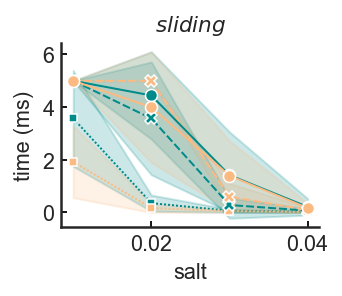

In [27]:
#custom_palette = sns.color_palette(["darkblue","lightblue","gold","yellow","darkcyan","cyan"])
custom_palette = sns.color_palette(["lightblue","lightpink","dodgerblue","red","cyan","darkorange"])

fig=plt.subplots(figsize = (2.5,2.2))
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=all_protein_sliding_record,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2,'darkcyan',o2,'darkcyan',o2],style="model",markers=True,ci='sd',err_style='band',\
             hue_order=['monomer recognition conformation','monomer search conformation',\
                        'dimer recognition conformation','dimer search conformation',\
                        'full dimer recognition conformation','full dimer search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(1.05, 1),\
         fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/sliding_time_all.png",dpi=300,transparent=True)

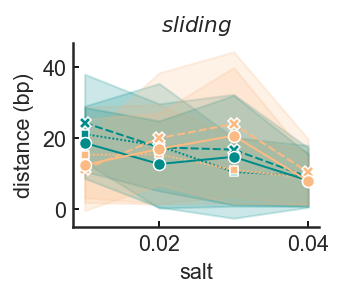

In [28]:
#custom_palette = sns.color_palette(["violet","red","lime","gold","darkcyan","darkorange"])
fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=all_protein_sliding_record,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2,'darkcyan',o2,'darkcyan',o2],style="model",markers=True,ci='sd',err_style='band',\
             hue_order=['monomer recognition conformation','monomer search conformation',\
                        'dimer recognition conformation','dimer search conformation','full dimer recognition conformation','full dimer search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/sliding_distance_all.png",dpi=300,transparent=True)

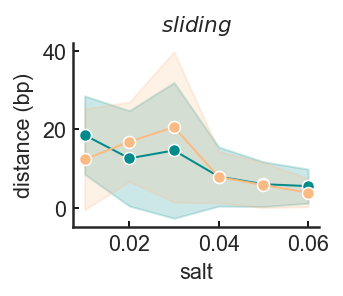

In [30]:
fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data_threeD,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/1D_distance.png",dpi=300,transparent=True)

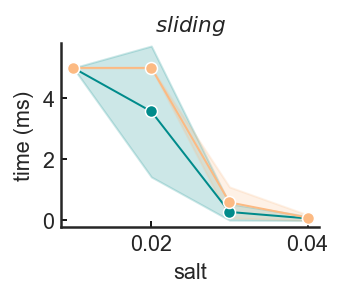

In [31]:
fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data_threeD_dimer,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style=None,marker='o',ci='sd',\
             hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding$')
#plt.yticks([0.0,2.5,5.0],[0.0,2.5,5.0],fontsize=10)
#plt.yticks([0.0,2.5,5.0],[0.0,2.5,5.0],fontsize=10)

#plt.ylim(-2,52)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.ylim(-0.2,5.8)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/SI/FigureS2/1D_time_dimer.png",dpi=300,transparent=True)

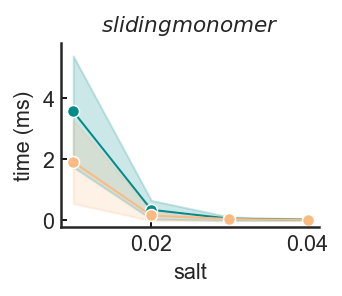

In [33]:
fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data_threeD_mono,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style=None,marker='o',ci='sd',\
             hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$sliding monomer$')
#plt.yticks([0.0,2.5,5.0],[0.0,2.5,5.0],fontsize=10)
#plt.yticks([0.0,2.5,5.0],[0.0,2.5,5.0],fontsize=10)
plt.ylim(-0.2,5.8)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/SI/FigureS2/1D_time_monomer.png",dpi=300,transparent=True)

# Run more analysis, groove tracking and *hopping*

## dimer

Note: Groove tracking is called sliding in the variables

In [34]:
S001_DBD_data=Dimer.combine_replica(dimerS001,'search conformation',0.01)
S002_DBD_data=Dimer.combine_replica(dimerS002,'search conformation',0.02)
S003_DBD_data=Dimer.combine_replica(dimerS003,'search conformation',0.03)
S004_DBD_data=Dimer.combine_replica(dimerS004,'search conformation',0.04)

R001_DBD_data=Dimer.combine_replica(dimerR001,'recognition conformation',0.01)
R002_DBD_data=Dimer.combine_replica(dimerR002,'recognition conformation',0.02)
R003_DBD_data=Dimer.combine_replica(dimerR003,'recognition conformation',0.03)
R004_DBD_data=Dimer.combine_replica(dimerR004,'recognition conformation',0.04)

/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 5
282 282
280 280
OK!
210 210
246 246
OK!
258 258
256 256
263 263
OK!
5 5
324 324
322 322
367 367
365 365
382 382
OK!
338 338
336 336
328 328
OK!
5 5
434 434
432 432
475 475
473 473
OK!
480 480
459 459
457 457
465 465
463 463
5 5
524 524
522 522
53 53
OK!
198 198
OK!
285 285
OK!
OK!
OK!
5 5
OK!
OK!
373 373
371 371
OK!
OK!
OK!
OK!
OK!
OK!
5 5
428 428
OK!
OK!
OK!
382 382
OK!
417 417
415 415
OK!
OK!
5 5
587 587
OK!
612 612
OK!
OK!
OK!
OK!
OK!
605 605
603 603
5 5
OK!
OK!
609 609
607 607
605 605
OK!
OK!
OK!
597 597
595 595


In [35]:
#concatenating for all salt concentrations
dataS_DBD_slides=pd.concat([S001_DBD_data[0],S002_DBD_data[0],S003_DBD_data[0],S004_DBD_data[0]])
dataS_DBD_hops=pd.concat([S001_DBD_data[1],S002_DBD_data[1],S003_DBD_data[1],S004_DBD_data[1]])
dataR_DBD_slides=pd.concat([R001_DBD_data[0],R002_DBD_data[0],R003_DBD_data[0],R004_DBD_data[0]])
dataR_DBD_hops=pd.concat([R001_DBD_data[1],R002_DBD_data[1],R003_DBD_data[1],R004_DBD_data[1]])
dataS_DBD_hops=dataS_DBD_hops[(dataS_DBD_hops['distance (bp)'] < 100) & (dataS_DBD_hops['distance (bp)'] > 5)]
#you use a window to determine the slididng area. The recorded hopping therefore is shortened by this window
#so add 2 bp of this window back to the distance travelled
dataS_DBD_hops.loc[:,'distance (bp)'] += 1.5
dataR_DBD_hops=dataR_DBD_hops[(dataR_DBD_hops['distance (bp)'] < 100) & (dataR_DBD_hops['distance (bp)'] > 5)]
dataR_DBD_hops.loc[:,'distance (bp)'] += 1.5

#concatenate for both conformations
data_DBD_slides=dataS_DBD_slides.append(dataR_DBD_slides)
data_DBD_hops=dataS_DBD_hops.append(dataR_DBD_hops)

#add speed, not really used, is it informative?
data_DBD_slides['speed (bp ms$^{-1}$)']=data_DBD_slides['distance (bp)']/data_DBD_slides['time (ms)']
data_DBD_hops['speed (bp ms$^{-1}$)']=data_DBD_hops['distance (bp)']/data_DBD_hops['time (ms)']

### plotting dimer

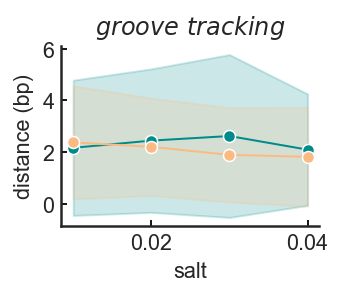

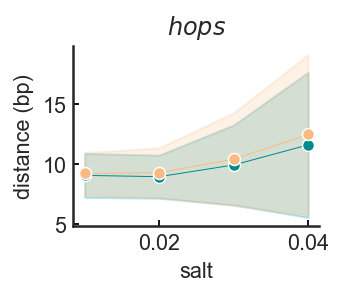

In [36]:
fig=plt.subplots(figsize = (2.5,2.2))
#get rid of outliers before plotting
data=data_DBD_slides#[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Sliding_distance_DBD.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#             palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])
sns.lineplot(data=data_DBD_hops,x='salt',y='distance (bp)',hue='protein'\
,linewidth=0.5,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.17, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()

plt.title('$hops$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Hopping_distance_DBD.png",dpi=300,transparent=True)

## monomer

In [44]:
S001_mono_data=monomer.combine_replica(monomerS001,'search conformation',0.01,5)
S002_mono_data=monomer.combine_replica(monomerS002,'search conformation',0.02,5)
S003_mono_data=monomer.combine_replica(monomerS003,'search conformation',0.03,5)
S004_mono_data=monomer.combine_replica(monomerS004,'search conformation',0.04,5)

R001_mono_data=monomer.combine_replica(monomerR001,'recognition conformation',0.01,5)
R002_mono_data=monomer.combine_replica(monomerR002,'recognition conformation',0.02,5)
R003_mono_data=monomer.combine_replica(monomerR003,'recognition conformation',0.03,5)
R004_mono_data=monomer.combine_replica(monomerR004,'recognition conformation',0.04,5)

/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
#concatenating for all salt concentrations
dataS_mono_slides=pd.concat([S001_mono_data[0],S002_mono_data[0],S003_mono_data[0],S004_mono_data[0]])
dataS_mono_hops=pd.concat([S001_mono_data[1],S002_mono_data[1],S003_mono_data[1],S004_mono_data[1]])
dataR_mono_slides=pd.concat([R001_mono_data[0],R002_mono_data[0],R003_mono_data[0],R004_mono_data[0]])
dataR_mono_hops=pd.concat([R001_mono_data[1],R002_mono_data[1],R003_mono_data[1],R004_mono_data[1]])
dataS_mono_hops=dataS_mono_hops[(dataS_mono_hops['distance (bp)'] < 100) & (dataS_mono_hops['distance (bp)'] > 5)]
#you use a window to determine the slididng area. The recorded hopping therefore is shortened by this window
#so add 2 bp of this window back to the distance travelled
dataS_mono_hops.loc[:,'distance (bp)'] += 1.5
dataR_mono_hops=dataR_mono_hops[(dataR_mono_hops['distance (bp)'] < 100) & (dataR_mono_hops['distance (bp)'] > 5)]
dataR_mono_hops.loc[:,'distance (bp)'] += 1.5

#concatenate for both conformations
data_mono_slides=dataS_mono_slides.append(dataR_mono_slides)
data_mono_hops=dataS_mono_hops.append(dataR_mono_hops)

#add speed, not really used, is it informative?
data_mono_slides['speed (bp ms$^{-1}$)']=data_mono_slides['distance (bp)']/data_mono_slides['time (ms)']
data_mono_hops['speed (bp ms$^{-1}$)']=data_mono_hops['distance (bp)']/data_mono_hops['time (ms)']

## plotting monomer

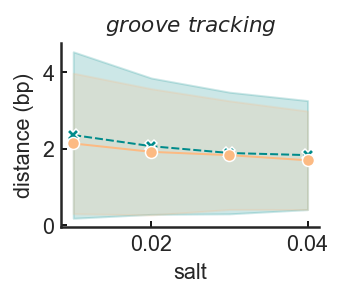

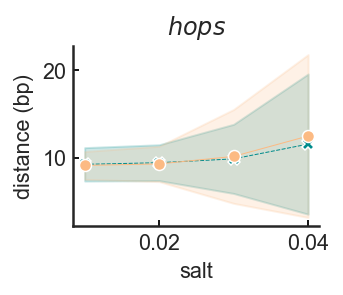

In [53]:
fig=plt.subplots(figsize = (2.5,2.2))
#get rid of outliers before plotting
data=data_mono_slides#[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Sliding_distance_mono.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#             palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])
sns.lineplot(data=data_mono_hops,x='salt',y='distance (bp)',hue='protein'\
,linewidth=0.5,palette=['darkcyan',o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.17, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()

plt.title('$hops$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Hopping_distance_mono.png",dpi=300,transparent=True)

## full dimer

In [47]:
#This gets the dataframes for sliding S001_data[0] and hopping S001_data[1]
#replica	start_frame	end_frame	start_position	end_position	
#time (ms)	distance (bp)	symmetry	flip_sign	protein	salt
S001_data=Dimer.combine_replica(full_dimerS001,'search conformation',0.01)
S002_data=Dimer.combine_replica(full_dimerS002,'search conformation',0.02)
S003_data=Dimer.combine_replica(full_dimerS003,'search conformation',0.03)
S004_data=Dimer.combine_replica(full_dimerS004,'search conformation',0.04)
S005_data=Dimer.combine_replica(full_dimerS005,'search conformation',0.05)
S006_data=Dimer.combine_replica(full_dimerS006,'search conformation',0.06)
R001_data=Dimer.combine_replica(full_dimerR001,'recognition conformation',0.01)
R002_data=Dimer.combine_replica(full_dimerR002,'recognition conformation',0.02)
R003_data=Dimer.combine_replica(full_dimerR003,'recognition conformation',0.03)
R004_data=Dimer.combine_replica(full_dimerR004,'recognition conformation',0.04)
R005_data=Dimer.combine_replica(full_dimerR005,'recognition conformation',0.05)
R006_data=Dimer.combine_replica(full_dimerR006,'recognition conformation',0.06)

/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mallu899/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8 8
OK!
Return only asymmeric events
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
OK!
OK!
OK!
OK!
8 8
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
8 8
OK!
OK!
OK!
OK!
OK!
122 122
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
5 5
OK!
OK!
OK!
OK!
OK!
113 113
OK!
Return only asymmeric events
OK!
OK!
5 5
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
5 5
Return only asymmeric events because no symmetric events were found.
Return only asymmeric events because no symmetric events were found.
OK!
OK!
52 52
OK!
OK!
OK!
OK!
OK!
8 8
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
8 8
OK!
58 58
75 75
OK!
OK!
68 68
82 82
OK!
OK!
61 61
OK!
OK!
OK!
OK!
OK!
58 58
8 8
OK!
OK!
OK!
112 112
OK!
127 127
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
5 5
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
5 5
OK!
OK!
OK!
OK!
OK!
OK!
OK!
80 80
5 5
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
Return only asymmeric events
Return only asymmeric events


In [54]:
#concatenating for all salt concentrations
dataS_slides=pd.concat([S001_data[0],S002_data[0],S003_data[0],S004_data[0],S005_data[0],S006_data[0]])
dataS_hops=pd.concat([S001_data[1],S002_data[1],S003_data[1],S004_data[1],S005_data[1],S006_data[1]])
dataR_slides=pd.concat([R001_data[0],R002_data[0],R003_data[0],R004_data[0],R005_data[0],R006_data[0]])
dataR_hops=pd.concat([R001_data[1],R002_data[1],R003_data[1],R004_data[1],R005_data[1],R006_data[1]])
dataS_hops=dataS_hops[(dataS_hops['distance (bp)'] < 100) & (dataS_hops['distance (bp)'] > 5)]
#you use a window to determine the slididng area. The recorded hopping therefore is shortened by this window
#so add 2 bp of this window back to the distance travelled
dataS_hops.loc[:,'distance (bp)'] += 1.5
dataR_hops=dataR_hops[(dataR_hops['distance (bp)'] < 100) & (dataR_hops['distance (bp)'] > 5)]
dataR_hops.loc[:,'distance (bp)'] += 1.5

#concatenate for both conformations
dimer_slides=dataS_slides.append(dataR_slides)
dimer_hops=dataS_hops.append(dataR_hops)

#add speed, not really used, is it informative?
dimer_slides['speed (bp ms$^{-1}$)']=dimer_slides['distance (bp)']/dimer_slides['time (ms)']
dimer_hops['speed (bp ms$^{-1}$)']=dimer_hops['distance (bp)']/dimer_hops['time (ms)']

#flips still do not work
#dataS_flips=([S001_data[2],S002_data[2],S003_data[2],S004_data[2],S005_data[2],S006_data[2]])
#dataR_flips=([R001_data[2],R002_data[2],R003_data[2],R004_data[2],R005_data[2],R006_data[2]])

In [55]:
dataS_hops.groupby('salt').mean()

,start_frame,end_frame,start_position,end_position,replica,time (ms),distance (bp),flip_sign
salt,,,,,,,,
0.01,36076.736842,36475.842105,-16.398895,-26.913316,4.631579,0.019955,9.119490,-18.943300
0.02,45573.421053,45958.905263,-30.334789,-33.369568,5.042105,0.019274,9.394207,1.480568
0.03,47674.414815,48355.362963,-12.085363,-12.439444,4.629630,0.034047,10.054624,3.208825
0.04,44729.671642,47087.223881,-11.626806,-8.620657,2.671642,0.117878,11.749163,-0.210432
0.05,26962.327586,29639.137931,-5.961190,-8.108638,2.879310,0.133841,11.019812,0.290219
0.06,16034.575000,19143.275000,-14.724375,-18.405075,3.300000,0.155435,10.897227,-8.250000


In [56]:
#get the average hop length
dataS_slides.groupby('salt').mean()

,replica,start_frame,end_frame,start_position,end_position,time (ms),distance (bp),flip_sign
salt,,,,,,,,
0.01,4.370370,21897.074074,51342.481481,-10.829037,-15.679148,1.472270,3.295455,-18.614105
0.02,5.179245,39668.877358,47039.084906,-30.427991,-31.359057,0.368510,1.905400,0.938099
0.03,4.637717,44590.352357,46351.853598,-10.994325,-10.629313,0.088075,1.736114,1.021336
0.04,2.633028,41965.279817,42697.490826,-11.863307,-12.376872,0.036611,1.562895,-2.086732
0.05,2.741228,36264.934211,36639.368421,-2.919263,-3.690390,0.018722,1.569337,0.647740
0.06,3.188525,20989.459016,21307.229508,-16.430459,-17.105508,0.015889,1.499295,-6.902419


### Compare full length, dimer DBD and monomer DBD

In [57]:
mono=data_mono_slides.replace({'search conformation':'monomer search conformation'\
                          ,'recognition conformation':'monomer recognition conformation'})
di=data_DBD_slides.replace({'search conformation':'dimer search conformation'\
                          ,'recognition conformation':'dimer recognition conformation'})
full=dimer_slides.replace({'search conformation':'full dimer search conformation'\
                          ,'recognition conformation':'full dimer recognition conformation'})
all_protein_groove_tracking_record=pd.concat([full[full['salt'].isin([0.01,0.02,0.03,0.04])],di,mono])

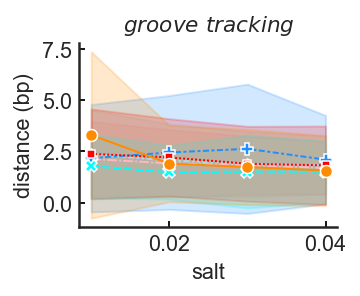

In [58]:
#custom_palette = sns.color_palette(["violet","red","lime","gold","darkcyan","darkorange"])
fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=all_protein_groove_tracking_record,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=custom_palette,style="protein",markers=True,ci='sd',err_style='band',\
             hue_order=['monomer recognition conformation','monomer search conformation',\
                        'dimer recognition conformation','dimer search conformation','full dimer recognition conformation','full dimer search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/groove_tracking_distance_all.png",dpi=300,transparent=True)

## Get the full length that is travelled groove tracking and hopping

In [59]:
#check how much time the protein spends in sliding or hopping totally and compare conformations
aggregate_time_distance_sliding_S=dataS_slides.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})
aggregate_time_distance_sliding_R=dataR_slides.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})
aggregate_time_distance_hopping_S=dataS_hops.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})
aggregate_time_distance_hopping_R=dataR_hops.groupby(['salt','replica'], as_index=False).agg({'time (ms)':'sum',\
            'distance (bp)':'sum'})
#add columns to identigft conformation and mode of facilitated diffusion
aggregate_time_distance_hopping_R['conformation']=['recognition conformation' for x in range(38)]
aggregate_time_distance_sliding_R['conformation']=['recognition conformation' for x in range(39)]
aggregate_time_distance_hopping_S['conformation']=['search conformation' for x in range(38)]
aggregate_time_distance_sliding_S['conformation']=['search conformation' for x in range(39)]
aggregate_time_distance_sliding_R['diffusion']=['$sliding$' for x in range(39)]
aggregate_time_distance_hopping_R['diffusion']=['$hopping$' for x in range(38)]
aggregate_time_distance_sliding_S['diffusion']=['$sliding$' for x in range(39)]
aggregate_time_distance_hopping_S['diffusion']=['$hopping$' for x in range(38)]
check_total_hopping=pd.concat([aggregate_time_distance_hopping_S,aggregate_time_distance_hopping_R])
check_total_sliding=pd.concat([aggregate_time_distance_sliding_S,aggregate_time_distance_sliding_R])

ValueError: Length of values does not match length of index

In [30]:
check_total_hopping.groupby('salt').mean()

,replica,time (ms),distance (bp)
salt,,,
0.01,4.500000,0.148603,52.187689
0.02,4.500000,0.398366,156.059830
0.03,4.500000,0.948903,360.625701
0.04,3.000000,1.192275,290.015000
0.05,3.111111,2.102772,258.383737
0.06,3.222222,2.279794,121.656128


In [31]:
check_total_sliding.groupby('salt').mean()

,replica,time (ms),distance (bp)
salt,,,
0.01,4.5,4.902494,15.426856
0.02,4.5,4.814456,30.762652
0.03,4.5,4.574928,88.483409
0.04,3.0,2.745235,119.145485
0.05,3.0,2.027405,112.043970
0.06,3.0,0.957380,49.698000


# Plotting

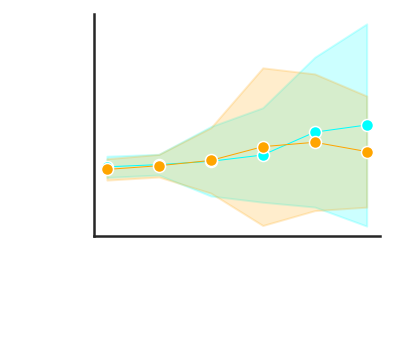

In [49]:
fig=plt.subplots(figsize = (3.,2.6),frameon=False,edgecolor='white')
sns.lineplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein'\
,linewidth=0.5,palette=['cyan','orange'],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])


plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='white',direction ='in')
#plt.title('full dimer')
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(1., 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
sns.despine()
#plt.ylim(-5,220)
#plt.xlim(0.008,0.045)
plt.xticks((0.01,0.02,0.03,0.04,0.05,0.06),(0.01,0.02,0.03,0.04,0.05,0.06),fontsize = 16,color='white',rotation=35)
plt.yticks(fontsize = 16,color='white')

plt.ylabel('length(bp)',fontsize = 16,color='white')
plt.xlabel('salt',fontsize = 16,color='white')
plt.tight_layout()
plt.savefig('/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/hop_length_presi',dpi=300,transparent=True)

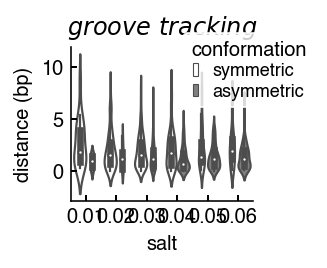

In [283]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
#sns.lineplot(data=data[data['protein']=='search conformation'],x='salt',y='distance (bp)',hue='symmetry'\
#              ,linewidth=1,palette=[g3,o2],style="symmetry",markers=True,ci='sd',hue_order=['asymmetric','symmetric'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
sns.violinplot(data=data[data['protein']=='search conformation'],x='salt',y='distance (bp)',hue='symmetry',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
#plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/Version9/Figure4_plots/Sliding_distance.png",dpi=300,transparent=True)

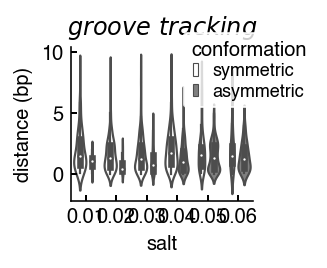

In [32]:
fig=plt.subplots(figsize = (2.2,2.))
#get rid of outliers before plotting
data=dimer_slides[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
#sns.lineplot(data=data[data['protein']=='search conformation'],x='salt',y='distance (bp)',hue='symmetry'\
#              ,linewidth=1,palette=[g3,o2],style="symmetry",markers=True,ci='sd',hue_order=['asymmetric','symmetric'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
sns.violinplot(data=data[data['protein']=='recognition conformation'],x='salt',y='distance (bp)',hue='symmetry',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
#plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()

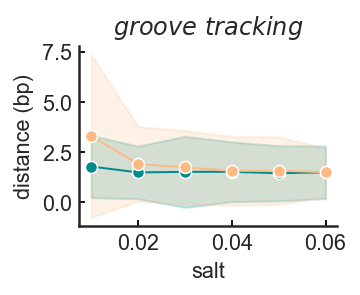

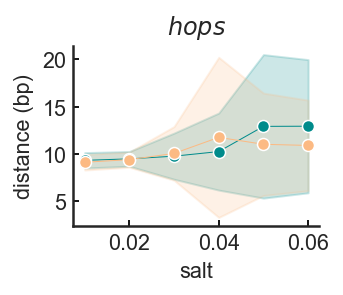

In [60]:
fig=plt.subplots(figsize = (2.5,2.2))
#get rid of outliers before plotting
data=dimer_slides#[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Sliding_distance.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#             palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])
sns.lineplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein'\
,linewidth=0.5,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.17, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()

plt.title('$hops$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Hopping_distance.png",dpi=300,transparent=True)

#### plotting for presentations

In [ ]:
fig=plt.subplots(figsize = (2.5,2.2))
#get rid of outliers before plotting
data=dimer_slides#[(dimer_slides['distance (bp)'] < 9)]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='distance (bp)',hue='protein'\
              ,linewidth=1,palette=['darkcyan',o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#            palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$',fonr)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)

#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Sliding_distance.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.5,2.2))

#sns.stripplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=0.7,\
#             palette=[o2,g2],size=2.9,alpha=0.9)
#sns.violinplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein',dodge=0.1,linewidth=1.1,scale='count',palette=['white','grey'])
sns.lineplot(data=dimer_hops,x='salt',y='distance (bp)',hue='protein'\
,linewidth=0.5,palette=['darkcyan',o2],style="protein",markers=True,ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.17, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()

plt.title('$hops$',fontsize=16,color='white')
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
#plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/Hopping_distance.png",dpi=300,transparent=True)

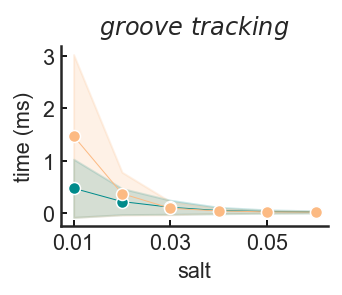

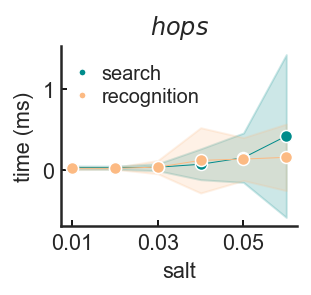

In [61]:
fig=plt.subplots(figsize = (2.5,2.2))
#get rid of outliers before plotting
data=dimer_slides[dimer_slides['distance (bp)'] < 20]
#sns.stripplot(data=data,x='salt',y='distance (bp)',hue='protein',dodge=0.1\
#              ,linewidth=0.5,alpha=0.6,palette=[o2,g2],size=3.5)
sns.lineplot(data=data,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=0.5,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
plt.title('$groove\ tracking$',fontsize=12)
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.xticks([0.01,0.03,0.05],[0.01,0.03,0.05])
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/sliding_time.png",dpi=300,transparent=True)

fig=plt.subplots(figsize = (2.5,2.2))
#sns.stripplot(data=dimer_hops,x='salt',y='time (ms)',hue='protein',dodge=0.1,linewidth=0.5,\
#              alpha=0.6,palette=[o2,g2],size=3.5)
#sns.violinplot(data=dimer_hops,x='salt',y='time (ms)',hue='protein',dodge=0.1,\
#             palette=[o2,g2])
sns.lineplot(data=dimer_hops,x='salt',y='time (ms)',hue='protein'\
              ,linewidth=0.5,palette=['darkcyan',o2],style=None,marker='o',ci='sd',hue_order=['recognition conformation','search conformation'])
plt.legend(['search','recognition'],edgecolor='white',loc='upper left',bbox_to_anchor=(0., 1.),
           markerscale=0.6,fontsize=10,ncol=1,labelspacing=0.2,handlelength=0.3)
#plt.legend([],[], frameon=False)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
#plt.ylim(-0.02,0.1)
plt.title('$hops$',fontsize=12)
plt.xticks([0.01,0.03,0.05],[0.01,0.03,0.05])
#plt.xticks(fontsize=9)
#plt.ylabel(fontsize = 9)
#plt.xlabel('Salt', fontsize = 9)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/hopping_time_legend.png",dpi=300,transparent=True)

In [65]:
#list of lists with time in 1D diffusion
d1_S=[d1S001_sum['time (ms)'],d1S002_sum['time (ms)'],d1S003_sum['time (ms)'],\
 d1S004_sum['time (ms)'],d1S005_sum['time (ms)'],d1S006_sum['time (ms)']]
d1_R=[d1R001_sum['time (ms)'],d1R002_sum['time (ms)'],d1R003_sum['time (ms)'],\
 d1R004_sum['time (ms)'],d1R005_sum['time (ms)'],d1R006_sum['time (ms)']]

In [62]:
def hopping_frequency(data_hops,data_1d,conformation,salt):
    """Calculate the frequency of hopping per ms from the 1D-diffusion time and the hopping count.
    
    Parameters
    ----------
    data_hops: list
        list of number of hops in one trajectory, which is the 4th output of the combined sliding and 
        hopping analysis (for example S001_data[3]).
    data_1d: coulumn of a pandas dataframe
        total time in 1D diffusion in each replica
    conformation: str
        conformation of the protein
    salt: float
        salt concentration
        
    Returns
    ------
    pandas Dataframe: $f_{hops}$ (ms$^{-1}$, conformation, salt"""
    
    all_hops = [x/y for x,y in zip(data_hops,data_1d)]
    data={'$f_{hops}$ (ms$^{-1}$)': all_hops,
         'conformation':[conformation for x in range(len(all_hops))],
         'salt':[salt for x in range(len(all_hops))]}
    return(pd.DataFrame(data))
def hopping_frequency_salts(data_hops,data_1d,conformation):
    """Calculate the frequency of hopping for different salt concentrations.
    
    Parameters
    ----------
    data_hops: list
        list of lists list of number of hops in one trajectory, which is the 4th output of 
        the combined sliding and hopping analysis (data_hops[i][3]).
    data_1d: coulumn of a pandas dataframe
        list of lists with total time in 1D diffusion in each replica
    conformation: str
        conformation of the protein
        
    Returns
    ------
    pandas Dataframe: $f_{hops}$ (ms$^{-1}$, conformation, salt"""
    
    salts=[0.01,0.02,0.03,0.04,0.05,0.06]
    salt_dfs=[]
    for i in range(len(salts)):
        salt_dfs.append(hopping_frequency(data_hops[i][3],data_1d[i],conformation,salts[i]))
    all_salts_df=pd.concat([x for x in salt_dfs])
    return(all_salts_df)

In [63]:
"""Experimental values based on
Marklund, E. et al. (2020). Nature
Nature. https://doi.org/10.1038/s41586-020-2413-7"""
fe_hops= np.random.normal(loc=4, scale=1, size=8)
exp=pd.DataFrame({'salt':[0.01 for x in \
                        range(len(fe_hops))]+[0.02 for x in range(len(fe_hops))]\
                  +[0.03 for x in range(len(fe_hops))]+[0.04 for x in range(len(fe_hops))]\
                  +[0.05 for x in range(len(fe_hops))]+[0.06 for x in range(len(fe_hops))],\
                  '$f_{hops}$ (ms$^{-1}$)':[x for x in fe_hops]*6,'conformation':['experimental' \
            for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]+\
                  ['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]+\
                  ['experimental' for x in range(len(fe_hops))]+['experimental' for x in range(len(fe_hops))]})

In [66]:
#get the hopping frequencies
hopping_f_S=hopping_frequency_salts([S001_data,S002_data,S003_data,\
                                   S004_data,S005_data,S006_data],d1_S,'search')
hopping_f_R=hopping_frequency_salts([R001_data,R002_data,R003_data,\
                                   R004_data,R005_data,R006_data],d1_R,'recognition')
hopping_f=pd.concat([hopping_f_S,hopping_f_R])
all_exp=hopping_f.append(exp)
#filter out outliers
from scipy.stats import zscore
absolute_zscore = np.abs(zscore(all_exp['$f_{hops}$ (ms$^{-1}$)']))
filter_outlierers = (absolute_zscore < 3)
all_exp_no_outlieres= all_exp[filter_outlierers]


In [67]:
hopping_f.groupby('salt').std()

,$f_{hops}$ (ms$^{-1}$)
salt,
0.01,0.793303
0.02,1.224803
0.03,1.193006
0.04,14.185780
0.05,3.057011
0.06,6.100606


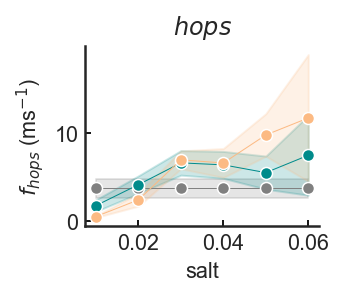

In [68]:
fig=plt.subplots(figsize = (2.5,2.2))
g=sns.lineplot(x='salt',y='$f_{hops}$ (ms$^{-1}$)',hue='conformation',data=all_exp_no_outlieres,linewidth=0.5\
            ,palette=['grey','darkcyan',o2],style=None,marker='o',ci='sd', hue_order=['experimental','recognition','search'])

plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(0.57, 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.title('$hops$',fontsize=12)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='k',direction ='in')
sns.despine()
#plt.yticks([0,1,2,3,4,5],[0,1,2,3,4,5],fontsize=9)
#plt.xticks(fontsize=9)
#b=sns.lineplot(x='salt',y='$f_{hops}$ (ms$^{-1}$)',data=exp,alpha=0.7,color='grey')
g.legend([],[], frameon=False)
#plt.ylim(0.005,17)
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/hopping_freq_norm.png",dpi=300,transparent=True)

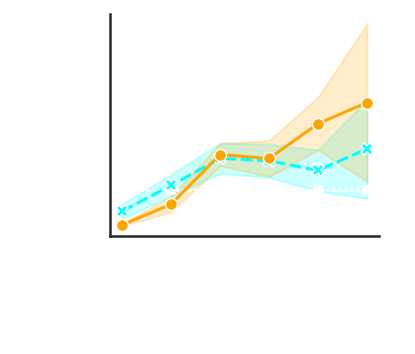

In [69]:
fig=plt.subplots(figsize = (3.,2.6),frameon=False,edgecolor='white')
g=sns.lineplot(x='salt',y='$f_{hops}$ (ms$^{-1}$)',hue='conformation',data=all_exp_no_outlieres\
            ,palette=['white','cyan','orange'],style="conformation",markers=True,ci='sd', hue_order=['experimental','recognition','search'])

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    right=False, left=True, labelleft=True,labelsize='medium',
    width = 1,
    length = 3, color='white',direction ='in')
#plt.title('full dimer')
plt.legend(title='conformation',edgecolor='white',loc='upper left',bbox_to_anchor=(1., 1.15),
           markerscale=0.6,fontsize=9,ncol=1,labelspacing=0.2,handlelength=0.3)
plt.legend([],[], frameon=False)
sns.despine()
#plt.ylim(-5,220)
#plt.xlim(0.008,0.045)
plt.xticks((0.01,0.02,0.03,0.04,0.05,0.06),(0.01,0.02,0.03,0.04,0.05,0.06),fontsize = 16,color='white',rotation=35)
plt.yticks(fontsize = 16,color='white')

plt.ylabel('$f_{hops}$ (ms$^{-1}$)',fontsize = 16,color='white')
plt.xlabel('salt',fontsize = 16,color='white')
plt.tight_layout()
plt.savefig("/Users/mallu899/Mirror/projects/lacI_CG_master/LacI_CG_Draft/Figures/version10/Figure4/hopping_freq_norm_presi.png",dpi=300,transparent=True)